<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99d_insurance_federated_wrapup_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

Open

- [ ] ~~RSquared for FL, but it is only available in tf-nightly and the installation broke the env~~
- [x] cache result
- [x] centralized: does CSV Logger work with TFF? Or instead save the hist manually as csv
- [x] logging/caching federated
- [ ] document input and outputs in FLutils
- [x] move to and test colab

## Prerequisites
---

### Libraries
---

In [1]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or possibly !pip install -r requirements.txt

    os.chdir("_dev")



COLAB? True
Cloning into 'fl-official-statistics-addon'...
remote: Enumerating objects: 2300, done.
remote: Counting objects: 100% (1482/1482), done.
remote: Compressing objects: 100% (831/831), done.
remote: Total 2300 (delta 755), reused 1360 (delta 643), pack-reused 818
Receiving objects: 100% (2300/2300), 62.69 MiB | 20.90 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
/content/fl-official-statistics-addon
Already up to date.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!python --version
# tested 3.9.* or 3.10.*.

Python 3.10.11


In [3]:
# show library versions
# =========================
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

tensorflow                    2.12.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-gcs-config         2.12.0
tensorflow-hub                0.13.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [4]:
# suppress tf debug logging
# =========================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [14]:
# imports
# =======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model,train_fed
#import FLutils

# logging path
out_path = '../output/experiments' 

### Data preperation
---

In [16]:
# ingest data
# ===========

df_paths = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_paths)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [17]:
# select features, target (first column) and clients
# ==================================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']

features_fed = features[:5]

target = 'charges'

clients = df.region.unique()

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Budget
---

#### Evaluation

In [18]:
# create evaluation splits
# ========================

nreps, nfolds = 3, 5
evaluation = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

#client_splits = [list(rsmp.split(data)) for data in clients]
#print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

#### Training

In [19]:
n_epochs     = 100
n_epochs_fed =  50
n_rounds_fed =  50  

### Model
---

In [20]:
# define model architecture
def keras_blueprint(compile = False, nfeatures = len(features_fed)):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

# loss = mae -> overfitting?

keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

## Federated Learning
---

In [21]:
experiment_name = '06_federated_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### FED Train 
---

In [22]:
# compute train
# =============
results_fed = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # distribute train (and eval) data over the client and prep tensors.
    train_data_fed = []
    eval_data_fed  = []   
    for client in clients:
        outer_train_data_client = df[(df.index.isin(train)) & (df.region == client)]
        train_data_client, eval_data_client = train_test_split(outer_train_data_client, test_size = 0.1, random_state = 42)
        
        train_data_fed.append(
            prep_fed_train(train_data_client[features_fed], train_data_client[target])) 
        eval_data_fed.append(
            prep_fed_test(eval_data_client[features_fed], eval_data_client[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result =  train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        NUM_ROUNDS = n_rounds_fed,
        NUM_EPOCHS = n_epochs_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )
    # caching
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    # load with e.g. 
    # model = keras_blueprint(compile = True)
    # model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    # model.weights

    results_fed.append(result)

100%|██████████| 4/4 [01:06<00:00, 16.63s/it]


In [23]:
# show train result
# =======================
table = pd.DataFrame([res['history'][-1] for res in results_fed])
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,4.00,4.0,4.0,4.00,4.0,4.00,4.0,4.0,4.0,4.0
mean,11074.09,255680384.0,260158768.0,4502.50,37.0,14820.81,383090016.0,386203744.0,103.0,4.0
std,322.41,5695930.0,3414376.0,2.89,0.0,1562.41,71088560.0,72041128.0,0.0,0.0
min,10816.28,250490832.0,257064000.0,4500.00,37.0,12586.49,277277824.0,278722848.0,103.0,4.0
25%,10916.02,251136216.0,257278152.0,4500.00,37.0,14357.93,375336784.0,380643816.0,103.0,4.0
50%,10967.43,255004064.0,260132744.0,4502.50,37.0,15301.86,412773008.0,416927824.0,103.0,4.0
75%,11125.49,259548224.0,263013360.0,4505.00,37.0,15764.74,420526232.0,422487760.0,103.0,4.0
max,11545.21,262222544.0,263305584.0,4505.00,37.0,16093.04,429536192.0,432236512.0,103.0,4.0


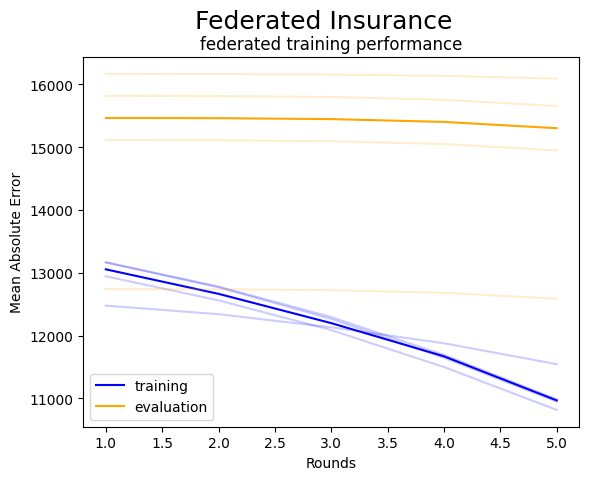

In [24]:
# plot train result (MAE)
# =======================
y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

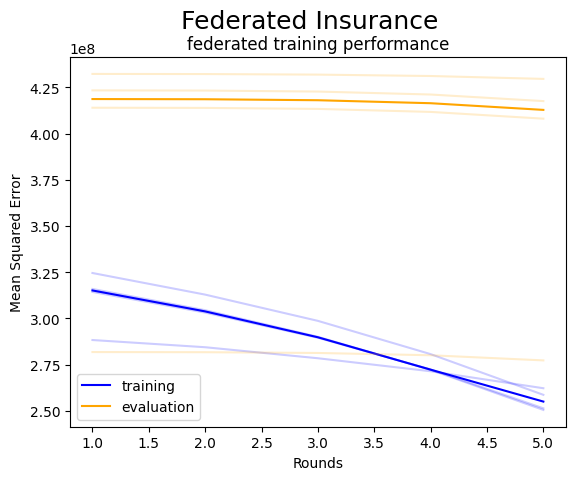

In [25]:
# plot train result (MSE)
# =======================

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test
---

In [26]:
# calculate test
# ==============
results_fed_test = []

model = keras_blueprint(compile = True)

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    X_test, y_test = data_test[features_fed], data_test[target]
    
    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    i += 1
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)


100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


In [27]:
# show test results
# =================
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,1.107409e+04,3.224052e+02,1.081628e+04,1.091602e+04,1.096743e+04,1.112549e+04,1.154521e+04
mean_squared_error,2.556804e+08,5.695930e+06,2.504908e+08,2.511362e+08,2.550041e+08,2.595482e+08,2.622225e+08
loss,2.601588e+08,3.414376e+06,2.570640e+08,2.572782e+08,2.601327e+08,2.630134e+08,2.633056e+08
num_examples,4.502500e+03,2.886800e+00,4.500000e+03,4.500000e+03,4.502500e+03,4.505000e+03,4.505000e+03
num_batches,3.700000e+01,0.000000e+00,3.700000e+01,3.700000e+01,3.700000e+01,3.700000e+01,3.700000e+01
val_mean_absolute_error,1.482081e+04,1.562414e+03,1.258649e+04,1.435793e+04,1.530186e+04,1.576474e+04,1.609304e+04
val_mean_squared_error,3.830900e+08,7.108856e+07,2.772778e+08,3.753368e+08,4.127730e+08,4.205262e+08,4.295362e+08
val_loss,3.862037e+08,7.204113e+07,2.787228e+08,3.806438e+08,4.169278e+08,4.224878e+08,4.322365e+08
val_num_examples,1.030000e+02,0.000000e+00,1.030000e+02,1.030000e+02,1.030000e+02,1.030000e+02,1.030000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

### Setup
---

Using 9 Features.

In [28]:
experiment_name = '07_central_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [29]:
# calculate training
# ==================
results_ctr = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))
    
    
    data_train = df.loc[train]
    X_train, y_train = data_train[features], data_train[target]

    model = keras_blueprint(nfeatures = len(features), compile = True)
    
    result = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        #output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42,
        verbose = False
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(result)


100%|██████████| 4/4 [00:37<00:00,  9.49s/it]


In [30]:
# show train results
# ==================
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,43043760.0,5035.02,43043760.0,69.15,38937784.0,4792.75,38937784.0,71.55
1,38594444.0,3991.09,38594444.0,72.80,38490076.0,4590.53,38490076.0,75.59
2,39407700.0,4096.12,39407700.0,70.34,40314700.0,4486.89,40314700.0,75.83
3,37785520.0,4020.79,37785520.0,74.99,37215328.0,4082.85,37215328.0,74.98


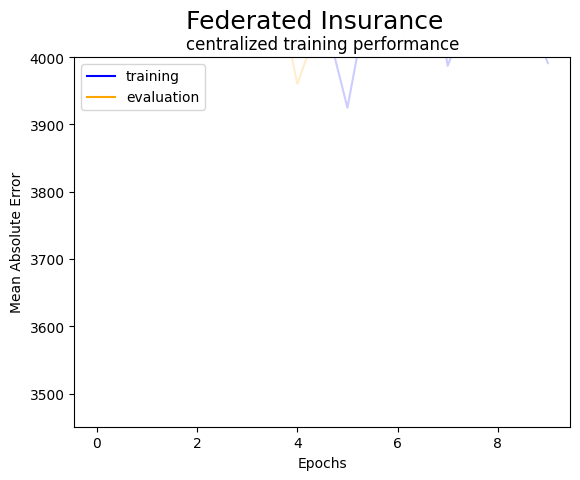

In [31]:
# plot train result (MAE)
# =======================
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


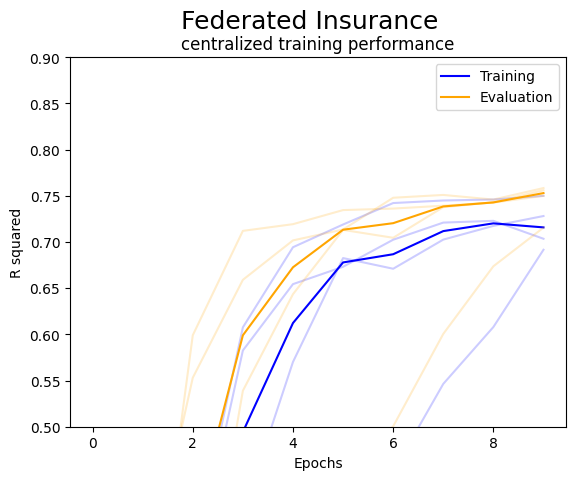

In [32]:
# plot train result (RSQ)
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [33]:
# compute test
# ============
results_test_ctr = []

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    
    X_test, y_test = data_test[features], data_test[target]
    
    
    model = results_ctr[i].model
    i += 1
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


In [34]:
# show test results
# =================
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,39707856.00,2320446.16,37785520.00,38392213.00,39001072.00,40316715.00,43043760.00
mae,4285.75,501.46,3991.09,4013.37,4058.46,4330.85,5035.02
mean_squared_error,39707856.00,2320446.16,37785520.00,38392213.00,39001072.00,40316715.00,43043760.00
r2_score,71.82,2.60,69.15,70.04,71.57,73.35,74.99
val_loss,38739472.00,1278786.43,37215328.00,38171389.00,38713930.00,39282013.00,40314700.00
val_mae,4488.25,298.63,4082.85,4385.88,4538.71,4641.08,4792.75
val_mean_squared_error,38739472.00,1278786.43,37215328.00,38171389.00,38713930.00,39282013.00,40314700.00
val_r2_score,74.49,1.99,71.55,74.12,75.28,75.65,75.83
test_loss,39424732.00,7519260.15,32705480.00,33718856.00,38081702.00,43787578.00,48830044.00
test_mae,4517.03,676.13,3882.39,4048.27,4396.07,4864.84,5393.56
